# Preprocessing comments for sentiment analysis
The comment contents pulled from reddit are creating various errors even after cleaning so I will temporarily be pulling the comments and processing them as dataframes directly instead of saving the data and reloading them.

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmaw import PushshiftAPI
import json
import datetime
import os
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
# instance of PushshiftAPI w/ default parameters
api = PushshiftAPI()

# start stop timestamps
before = int(datetime.datetime(2022,1,1,0,0).timestamp())
after = int(datetime.datetime(2021,1,1,0,0).timestamp())

# filter for submissions
s_filter = ['created_utc', 'title', 'id']

# filter for comments
c_filter = ['created_utc', 'body', 'id']

# variable setting limit to number of comments pulled
limit = 300000

In [3]:
"""Function for pulling reddit comments"""
def reddit_comments(term, subreddit, before, after, c_filter, limit):
    comments = api.search_comments(q=term,
                                   subreddit=subreddit,
                                   before=before,
                                   after=after,
                                   filter=c_filter,
                                   limit=limit)
    # create dataframe from pushshift response object
    c_df = pd.DataFrame(comments)
    # remove all '#' from 'body' column
    c_df['body'].str.replace('#', '')
    # convert comment utc timestamp to datetime
    c_df['datetime'] = c_df['created_utc'].apply(lambda x: datetime.datetime.fromtimestamp(x))
    c_df = c_df.drop(columns=['created_utc'])
    # return dataframe
    return c_df

In [4]:
# pull comments from r/Cryptocurrency mentioning 'lrc' and 'loopring'
cc_lrc_c = reddit_comments('lrc', 'cryptocurrency', before, after, c_filter, limit)
print(f'Retrieved {len(cc_lrc_c)} comments from Pushshift')
cc_loopring_c = reddit_comments('loopring', 'cryptocurrency', before, after, c_filter, limit)
print(f'Retrieved {len(cc_loopring_c)} comments from Pushshift')


# pull comments from r/SuperStonk mentioning 'lrc' and 'loopring'
ss_lrc_c = reddit_comments('lrc', 'superstonk', before, after, c_filter, limit)
print(f'Retrieved {len(ss_lrc_c)} comments from Pushshift')
ss_loopring_c = reddit_comments('loopring', 'superstonk', before, after, c_filter, limit)
print(f'Retrieved {len(ss_loopring_c)} comments from Pushshift')

Retrieved 49824 comments from Pushshift
Retrieved 12165 comments from Pushshift
Retrieved 9543 comments from Pushshift
Retrieved 14382 comments from Pushshift


In [5]:
# Join all r/CryptoCurrency comments including body
cc_comments = pd.concat([cc_lrc_c, cc_loopring_c])
cc_comments = cc_comments.sort_values(by=['datetime'])

# Join all r/SuperStonk comments including body
ss_comments = pd.concat([ss_lrc_c, ss_loopring_c])
ss_comments = ss_comments.sort_values(by=['datetime'])

# All comments
all_comments = pd.concat([cc_lrc_c, cc_loopring_c, ss_lrc_c, ss_loopring_c])

# remove all duplicate comments
print(len(all_comments))
comments = all_comments.drop_duplicates(subset='id')
print(len(comments))

# sort by datetime
comments = comments.sort_values(by=['datetime'])

# turn datetime column into index
comments = comments.set_index('datetime')


85914
82836


In [6]:
# 2022 Comment Data

before_2022 = int(datetime.datetime(2022,7,1,0,0).timestamp())
after_2022 = int(datetime.datetime(2022,1,1,0,0).timestamp())


# pull 2022 comments from r/CryptoCurrency & r/SuperStonk mentioning 'lrc' and 'loopring'
cc_lrc_22 = reddit_comments('lrc', 'cryptocurrency', before_2022, after_2022, c_filter, limit)
print(f'Retrieved {len(cc_lrc_22)} comments from Pushshift')
cc_loopring_22 = reddit_comments('loopring', 'cryptocurrency', before_2022, after_2022, c_filter, limit)
print(f'Retrieved {len(cc_loopring_22)} comments from Pushshift')

ss_lrc_22 = reddit_comments('lrc', 'superstonk', before_2022, after_2022, c_filter, limit)
print(f'Retrieved {len(ss_lrc_22)} comments from Pushshift')
ss_loopring_22 = reddit_comments('loopring', 'superstonk', before_2022, after_2022, c_filter, limit)
print(f'Retrieved {len(ss_loopring_22)} comments from Pushshift')

# combine comments
cc_comments22 = pd.concat([cc_lrc_22, cc_loopring_22])
cc_comments22 = cc_comments.sort_values(by=['datetime'])

ss_comments22 = pd.concat([ss_lrc_22, ss_loopring_22])
ss_comments22 = ss_comments.sort_values(by=['datetime'])

all_comments22 = pd.concat([cc_lrc_22, cc_loopring_22, ss_lrc_22, ss_loopring_22])

# remove all duplicate comments
print(len(all_comments22))
comments_22 = all_comments22.drop_duplicates(subset='id')
print(len(comments_22))

# sort by datetime
comments_22 = comments_22.sort_values(by=['datetime'])

# turn datetime column into index
comments_22 = comments_22.set_index('datetime')

Retrieved 20615 comments from Pushshift
Retrieved 6904 comments from Pushshift
Retrieved 11770 comments from Pushshift
Retrieved 18792 comments from Pushshift
58081
54668


## Sentiment Analysis on comments

In [7]:
# download lexicon
nltk.download('vader_lexicon')

# instantiate sentiment analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\dkang\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
# Update lexicon

# word list to add wsb/reddit flavour to vader to improve sentiment analysis, score: 4.0 to -4.0
new_words = {
    'hindenburg': -4.0,        
    'moon': 4.0,
    'highs': 2.0,
    'mooning': 4.0,
    'long': 2.0,
    'short': -2.0,
    'call': 4.0,
    'calls': 4.0,    
    'put': -4.0,
    'puts': -4.0,    
    'break': 2.0,
    'tendie': 2.0,
    'tendies': 2.0,
    'town': 2.0,
    'btfd': 2.0,     
    'overvalued': -3.0,
    'undervalued': 3.0,
    'buy': 4.0,
    'sell': -4.0,
    'gone': -1.0,
    'gtfo': -1.7,
    'paper': -1.7,
    'bullish': 3.7,
    'bearish': -3.7,
    'bagholder': -1.7,
    'stonk': 1.9,
    'green': 1.9,
    'money': 1.2,
    'print': 2.2,
    'rocket': 2.2,
    'bull': 4.0,
    'bear': -4.0,
    'pumping': -1.0,
    'dumping': -2.0,
    'diamond': 4,
    'sus': -3.0,
    'offering': -2.3,
    'rip': -4.0,
    'downgrade': -3.0,
    'upgrade': 3.0,     
    'maintain': 1.0,          
    'pump': 1.9,
    'hot': 1.5,
    'drop': -2.5,
    'dump': -2.5,
    'rebound': 1.5,  
    'crack': 2.5,
    'gang': 2.0,
    'scam': -2.0,
    'chamath': -2.0,
    'snake': -2.0,
    'squeeze': 3.0,
    'bag': -4.0,
    'fly': 2.0,     
    'way': 2.0,     
    'high': 2.0,
    'volume': 2.5,
    'low': -2.0,
    'trending': 3.0,
    'upwards': 3.0,
    'prediction': 1.0,     
    'cult': -1.0,     
    'big': 2.0,
    'hodl': 4.0,
    'hold': 4.0
    }

sia.lexicon.update(new_words)

In [9]:
# dataframe with just comments by date
c21_sia = pd.DataFrame(comments['body'])

# add column with polarity scores for comment
c21_sia['scores'] = c21_sia['body'].apply(lambda body:sia.polarity_scores(body))

# add column with compound score
c21_sia['compound'] = c21_sia['scores'].apply(lambda score_dict: score_dict['compound'])

# add column for positive or negative sentiment based on compound score
c21_sia['comp_score'] = c21_sia['compound'].apply(lambda c: '1' if c >=0 else '-1')

c21_sia = c21_sia[['compound', 'comp_score']]
c21_sia['comp_score'] = pd.to_numeric(c21_sia['comp_score'])

In [10]:
# Calculate daily sentiment polarity for 2021 comments
daily_sentiment_21 = c21_sia.groupby(c21_sia.index.date).mean()
daily_sentiment_21.index = pd.to_datetime(daily_sentiment_21.index)

# create empty dataframe with an index entry for every day of 2021
datelist = pd.DataFrame({'date': pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')})
datelist.set_index('date', inplace=True)

# merge daily comments with empty year dataframe to have a full year including days with no comments
daily_sentiment_21 = pd.concat([datelist, daily_sentiment_21], axis=1)
daily_sentiment_21[['compound', 'comp_score']] = daily_sentiment_21[['compound', 'comp_score']].fillna(0)
daily_sentiment_21

,compound,comp_score
2021-01-01,0.437800,1.000000
2021-01-02,0.802000,1.000000
2021-01-03,0.056817,0.448276
2021-01-04,0.130405,0.513514
2021-01-05,0.387659,0.746032
...,...,...
2021-12-27,0.261977,0.675000
2021-12-28,0.253328,0.638393
2021-12-29,0.250390,0.628346
2021-12-30,0.238273,0.646724


In [11]:
# dataframe with just comments by date
c22_sia = pd.DataFrame(comments_22['body'])

# add column with polarity scores for comment
c22_sia['scores'] = c22_sia['body'].apply(lambda body:sia.polarity_scores(body))

# add column with compound score
c22_sia['compound'] = c22_sia['scores'].apply(lambda score_dict: score_dict['compound'])

# add column for positive or negative sentiment based on compound score
c22_sia['comp_score'] = c22_sia['compound'].apply(lambda c: '1' if c >=0 else '-1')

c22_sia = c22_sia[['compound', 'comp_score']]
c22_sia['comp_score'] = pd.to_numeric(c22_sia['comp_score'])
c22_sia

,compound,comp_score
datetime,,
2022-01-01 00:03:51,0.0000,1
2022-01-01 00:04:21,0.0000,1
2022-01-01 00:08:14,-0.9185,-1
2022-01-01 00:10:04,0.0000,1
2022-01-01 00:12:16,0.0000,1
...,...,...
2022-06-30 23:27:17,0.7184,1
2022-06-30 23:45:04,0.0000,1
2022-06-30 23:47:06,0.7500,1


In [12]:
# Calculate daily sentiment polarity for 2022 comments
daily_sentiment_22 = c22_sia.groupby(c22_sia.index.date).mean()
daily_sentiment_22.index = pd.to_datetime(daily_sentiment_22.index)

# create empty dataframe with an index entry for every day of 2021
datelist = pd.DataFrame({'date': pd.date_range(start='2022-01-01', end='2022-06-30', freq='D')})
datelist.set_index('date', inplace=True)

# merge daily comments with empty year dataframe to have a full year including days with no comments
daily_sentiment_22 = pd.concat([datelist, daily_sentiment_22], axis=1)
daily_sentiment_22[['compound', 'comp_score']] = daily_sentiment_22[['compound', 'comp_score']].fillna(0)
daily_sentiment_22

,compound,comp_score
2022-01-01,0.336868,0.695749
2022-01-02,0.267914,0.663244
2022-01-03,0.273708,0.696335
2022-01-04,0.239235,0.660000
2022-01-05,0.205706,0.558233
...,...,...
2022-06-26,0.307705,0.694118
2022-06-27,0.371528,0.702970
2022-06-28,0.340151,0.685393
2022-06-29,0.285605,0.536913


## Format comment data for analysis

In [13]:
# Create a dataframe with a count of comments per day in 2021

# create column to count comments per day
comments_per_day_21 = comments.groupby(by=comments.index.date).count()
comments_per_day_21 = pd.DataFrame(comments_per_day_21['body'])
comments_per_day_21.rename(columns={'body': 'count'}, inplace=True)
comments_per_day_21.index = pd.to_datetime(comments_per_day_21.index)

# create empty dataframe with an index entry for every day of 2021
datelist = pd.DataFrame({'date': pd.date_range(start='2021-01-01', end='2021-12-31', freq='D')})
datelist.set_index('date', inplace=True)

# merge daily comments with empty year dataframe to have a full year including days with no comments
comments_per_day_21 = pd.concat([datelist, comments_per_day_21], axis=1)
comments_per_day_21['count'] = comments_per_day_21['count'].fillna(0)
comments_per_day_21.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2021-01-01 to 2021-12-31
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   365 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB


In [14]:
# Create a dataframe with a count of comments per day in 2022

# create column to count comments per day
comments_per_day_22 = comments_22.groupby(by=comments_22.index.date).count()
comments_per_day_22 = pd.DataFrame(comments_per_day_22['body'])
comments_per_day_22.rename(columns={'body': 'count'}, inplace=True)
comments_per_day_22.index = pd.to_datetime(comments_per_day_22.index)

# create empty dataframe with an index entry for every day of 2021
datelist_22 = pd.DataFrame({'date': pd.date_range(start='2022-01-01', end='2022-07-01', freq='D')})
datelist_22.set_index('date', inplace=True)

# merge daily comments with empty year dataframe to have a full year including days with no comments
comments_per_day_22 = pd.concat([datelist_22, comments_per_day_22], axis=1)
comments_per_day_22['count'] = comments_per_day_22['count'].fillna(0)
comments_per_day_22.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2022-01-01 to 2022-07-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   count   182 non-null    float64
dtypes: float64(1)
memory usage: 2.8 KB


## Load LRC price data

In [15]:
# load price data
price_day = pd.read_csv('data/daily_lrc_price_dat.csv')

In [35]:
# Format and structure price data
price_daily = price_day[['date', 'close', 'volumeto']]
price_daily['log_ret'] = np.log(price_daily.close) - np.log(price_daily.close.shift(1))
price_daily['returns'] = price_daily['close'].pct_change()
price_daily = price_daily.rename(columns={'date': 'datetime'})
price_daily.index = pd.to_datetime(price_daily['datetime'])
price_daily.index = price_daily.index.normalize()
price_daily = price_daily[['close', 'volumeto','log_ret', 'returns']]

# dataframes separated by year
price_daily_21 = price_daily.loc['2021-01-01':'2021-12-31']
price_daily_22 = price_daily.loc['2022-01-01':'2022-06-30']

price_daily = price_daily.loc['2021-01-01':'2022-06-30']

price_daily_21

,close,volumeto,log_ret,returns
datetime,,,,
2021-01-01,0.1756,1.350045e+06,-0.002275,-0.002273
2021-01-02,0.2931,2.376341e+07,0.512305,0.669134
2021-01-03,0.3637,9.786243e+07,0.215816,0.240873
2021-01-04,0.4818,2.223103e+08,0.281200,0.324718
2021-01-05,0.4055,1.041007e+08,-0.172408,-0.158364
...,...,...,...,...
2021-12-27,2.0580,4.737485e+07,-0.092745,-0.088574
2021-12-28,1.9750,2.640857e+07,-0.041166,-0.040330
2021-12-29,1.9950,2.476013e+07,0.010076,0.010127


In [36]:
# Combine price and comment sentiment data for 2021 and 2022
daily_21 = pd.merge(comments_per_day_21, price_daily_21, left_index=True, right_index=True)
daily_22 = pd.merge(comments_per_day_22, price_daily_22, left_index=True, right_index=True)

daily_21 = pd.merge(daily_21, daily_sentiment_21, left_index=True, right_index=True)
daily_22 = pd.merge(daily_22, daily_sentiment_22, left_index=True, right_index=True)
daily = pd.concat([daily_21, daily_22])

In [37]:
daily_21.to_csv('daily_21.csv', index=True)
daily_22.to_csv('daily_22.csv', index=True)
daily.to_csv('daily.csv', index=True)

array([[<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'close'}>],
       [<AxesSubplot:title={'center':'volumeto'}>,
        <AxesSubplot:title={'center':'returns'}>],
       [<AxesSubplot:title={'center':'compound'}>,
        <AxesSubplot:title={'center':'comp_score'}>]], dtype=object)

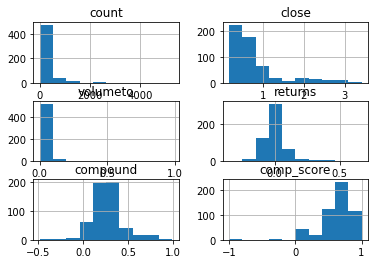

In [19]:
daily.hist()

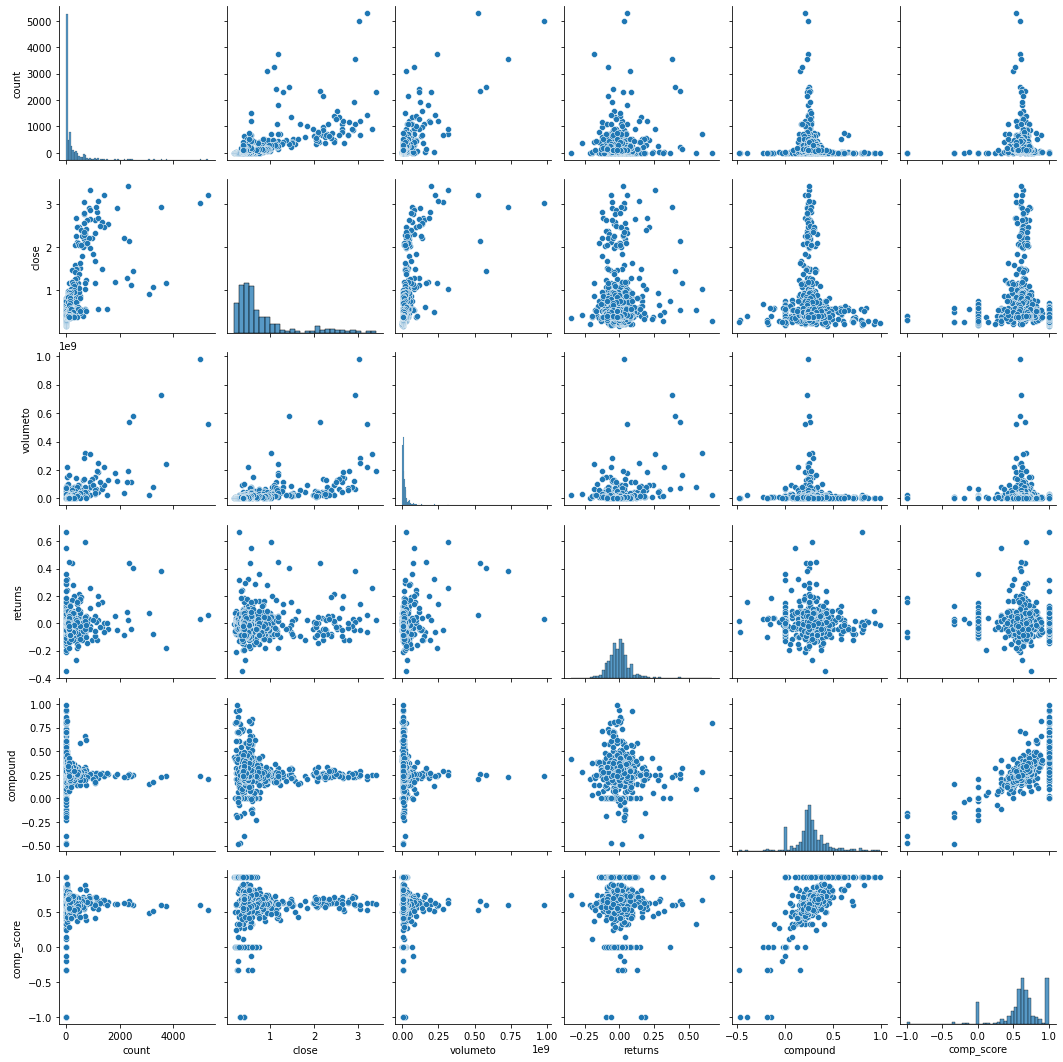

In [20]:
sns.pairplot(daily)

### Does the volume of comments Granger cause the return of LRC?

In [21]:
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

In [22]:
# ADF testing comment count data for stationarity
X = daily['count']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.783833
p-value: 0.003077
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [23]:
X = daily['returns']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.393898
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [24]:
X = daily['close']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.371736
p-value: 0.149873
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [25]:
X = daily['compound']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.999634
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [26]:
X = daily['comp_score']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.861619
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [27]:
grangercausalitytests(daily[['close', 'count']], maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=13.1545 , p=0.0000  , df_denom=536, df_num=3
ssr based chi2 test:   chi2=39.9790 , p=0.0000  , df=3
likelihood ratio test: chi2=38.5757 , p=0.0000  , df=3
parameter F test:         F=13.1545 , p=0.0000  , df_denom=536, df_num=3


{3: ({'ssr_ftest': (13.154533437013765, 2.674073254849906e-08, 536.0, 3),
   'ssr_chi2test': (39.9789831509243, 1.0764951637607166e-08, 3),
   'lrtest': (38.57570624162781, 2.1347092933770126e-08, 3),
   'params_ftest': (13.15453343697187, 2.6740732550027073e-08, 536.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [28]:
grangercausalitytests(daily[['returns', 'count']], maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5306  , p=0.2056  , df_denom=536, df_num=3
ssr based chi2 test:   chi2=4.6519  , p=0.1991  , df=3
likelihood ratio test: chi2=4.6321  , p=0.2008  , df=3
parameter F test:         F=1.5306  , p=0.2056  , df_denom=536, df_num=3


{3: ({'ssr_ftest': (1.5306372116725768, 0.20555756530996802, 536.0, 3),
   'ssr_chi2test': (4.6518806302511715, 0.19913641650249786, 3),
   'lrtest': (4.632067380798617, 0.2008083777445555, 3),
   'params_ftest': (1.530637211673013, 0.2055575653098553, 536.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [29]:
grangercausalitytests(daily[['returns', 'compound']], maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3066  , p=0.2715  , df_denom=536, df_num=3
ssr based chi2 test:   chi2=3.9709  , p=0.2646  , df=3
likelihood ratio test: chi2=3.9564  , p=0.2662  , df=3
parameter F test:         F=1.3066  , p=0.2715  , df_denom=536, df_num=3


{3: ({'ssr_ftest': (1.3065589610863082, 0.2714537692796366, 536.0, 3),
   'ssr_chi2test': (3.970866693301486, 0.26462723370374874, 3),
   'lrtest': (3.9564179547678577, 0.26620882271725027, 3),
   'params_ftest': (1.3065589610862816, 0.2714537692796418, 536.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [30]:
grangercausalitytests(daily[['returns', 'compound']], maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3066  , p=0.2715  , df_denom=536, df_num=3
ssr based chi2 test:   chi2=3.9709  , p=0.2646  , df=3
likelihood ratio test: chi2=3.9564  , p=0.2662  , df=3
parameter F test:         F=1.3066  , p=0.2715  , df_denom=536, df_num=3


{3: ({'ssr_ftest': (1.3065589610863082, 0.2714537692796366, 536.0, 3),
   'ssr_chi2test': (3.970866693301486, 0.26462723370374874, 3),
   'lrtest': (3.9564179547678577, 0.26620882271725027, 3),
   'params_ftest': (1.3065589610862816, 0.2714537692796418, 536.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [31]:
grangercausalitytests(daily[['close', 'compound']], maxlag=[3])


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4425  , p=0.7227  , df_denom=536, df_num=3
ssr based chi2 test:   chi2=1.3450  , p=0.7185  , df=3
likelihood ratio test: chi2=1.3433  , p=0.7189  , df=3
parameter F test:         F=0.4425  , p=0.7227  , df_denom=536, df_num=3


{3: ({'ssr_ftest': (0.4425469892686903, 0.7226762025109535, 536.0, 3),
   'ssr_chi2test': (1.3449795625348815, 0.7184809446182241, 3),
   'lrtest': (1.3433165897736217, 0.7188737167806452, 3),
   'params_ftest': (0.44254698926869623, 0.7226762025109394, 536.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}